In [0]:
%matplotlib inline
from fastai.vision import *
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import os

In [23]:
colab = True
if colab:
  from google.colab import drive
  drive.mount('/content/drive', force_remount = True)
  %cp "/content/drive/My Drive/autoencoder-training/data.zip" .
  %cp "/content/drive/My Drive/autoencoder-training/baseline-Cifar10.pt" .
  %cp "/content/drive/My Drive/autoencoder-training/featureLoss-Cifar10.pt" .
  %cp "/content/drive/My Drive/autoencoder-training/pixelShuffle-Cifar10.pt" .
  %cp "/content/drive/My Drive/autoencoder-training/preTrained-Cifar10.pt" .
  %cp "/content/drive/My Drive/autoencoder-training/preTrainednonwWeights-Cifar10.pt" .
  %cp "/content/drive/My Drive/autoencoder-training/progResizing-Cifar10.pt" .

  %cp "/content/drive/My Drive/autoencoder-training/baseline_model.py" .
  %cp "/content/drive/My Drive/autoencoder-training/model_layers.py" .
  %cp "/content/drive/My Drive/autoencoder-training/featureLoss_function.py" .
  %cp "/content/drive/My Drive/autoencoder-training/pixelShuffle_model.py" .
  %cp "/content/drive/My Drive/autoencoder-training/pretrainedModel.py" .
  %cp "/content/drive/My Drive/autoencoder-training/progressiveResizing_model.py" .
  !unzip -q data.zip
  image_path = "data"
  import baseline_model
  import model_layers
  import featureLoss_function
  import pixelShuffle_model
  import pretrainedModel
  import progressiveResizing_model
else: 
  os.chdir("../")
  image_path = os.getcwd() + "/data"

Mounted at /content/drive
replace __MACOSX/data/._valid? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Cifar10 Classification Accuracy

This notebook is going to train a classifier on the Cifar-10 dataset and then used the previously trainined autoencoders to recreate input images. If the model can still recognise the ouput correctly then the recreated image is "good enough".

In [0]:
data = ImageDataBunch.from_folder(image_path, size=32,ds_tfms=get_transforms(p_affine=0), bs = 128
                                 ).normalize(imagenet_stats)

In [6]:
len(data.train_ds), len(data.valid_ds)

(50000, 10000)

### Training

In [7]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [8]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 16, 16]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 16, 16]         128        True      
______________________________________________________________________
ReLU                 [64, 16, 16]         0          False     
______________________________________________________________________
MaxPool2d            [64, 8, 8]           0          False     
______________________________________________________________________
Conv2d               [64, 8, 8]           36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 8, 8]           128        True      
______________________________________________________________________
ReLU                 [64, 8, 8]           0          False     
___________________________________________________

In [9]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.548381,1.373147,0.474100,00:59


In [10]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.75E-06
Min loss divided by 10: 3.31E-03


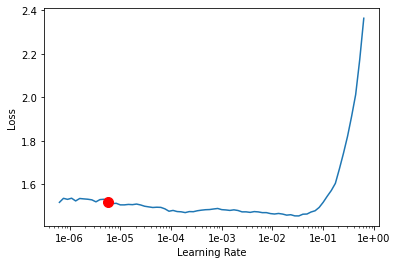

In [11]:
learn.recorder.plot(suggestion = True)

In [12]:
learn.fit_one_cycle(10, max_lr = 1.74E-03)

epoch,train_loss,valid_loss,error_rate,time
0,1.328910,1.184034,0.414100,00:58
1,1.035616,0.916500,0.321600,00:58
2,0.879706,0.795590,0.277400,00:58
3,0.794513,0.732633,0.257800,00:58
4,0.727042,0.698843,0.246200,00:57
5,0.679900,0.658929,0.231900,00:57
6,0.650344,0.640198,0.228300,00:57
7,0.628336,0.624759,0.220700,00:58
8,0.598673,0.623662,0.220800,00:58
9,0.590174,0.620828,0.218500,00:58


In [13]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr = slice(1e-06, 1e-03))

epoch,train_loss,valid_loss,error_rate,time
0,0.582996,0.612214,0.214600,01:03
1,0.582742,0.601753,0.213000,01:02
2,0.563818,0.587627,0.204900,01:02
3,0.512999,0.564730,0.199300,01:02
4,0.455378,0.554185,0.190700,01:02
5,0.399759,0.552012,0.185700,01:03
6,0.345247,0.552204,0.179400,01:03
7,0.304994,0.558736,0.180800,01:03
8,0.286655,0.564755,0.182300,01:02
9,0.274175,0.565658,0.182100,01:02


In [0]:
torch.save(learn.model, "baselineClassification.pt")
torch.save(learn.model, "/content/drive/My Drive/autoencoder-training/baselineClassification.pt")

## Classification Accuracy

### Baseline Autoencoder

In [0]:
class baseline(nn.Module):
    def __init__(self):
        super(baseline, self).__init__()

        self.autoencoder = torch.load("baseline-Cifar10.pt")
        self.classifier = torch.load("baselineClassification.pt")
        self.mean = torch.tensor(imagenet_stats[0]).cuda()
        self.std = torch.tensor(imagenet_stats[1]).cuda()

    def forward(self, x):
        x = torch.clamp(self.autoencoder(x), min=0, max=1)
        x = (x - self.mean[...,None,None])/self.std[...,None,None]
        x = self.classifier(x)
        return x

In [0]:
baseline_evaluation = baseline()
learn = Learner(data, baseline_evaluation, metrics = [error_rate, accuracy])

In [49]:
learn.validate(learn.data.valid_dl)

[2.2826636, tensor(0.5442), tensor(0.4558)]

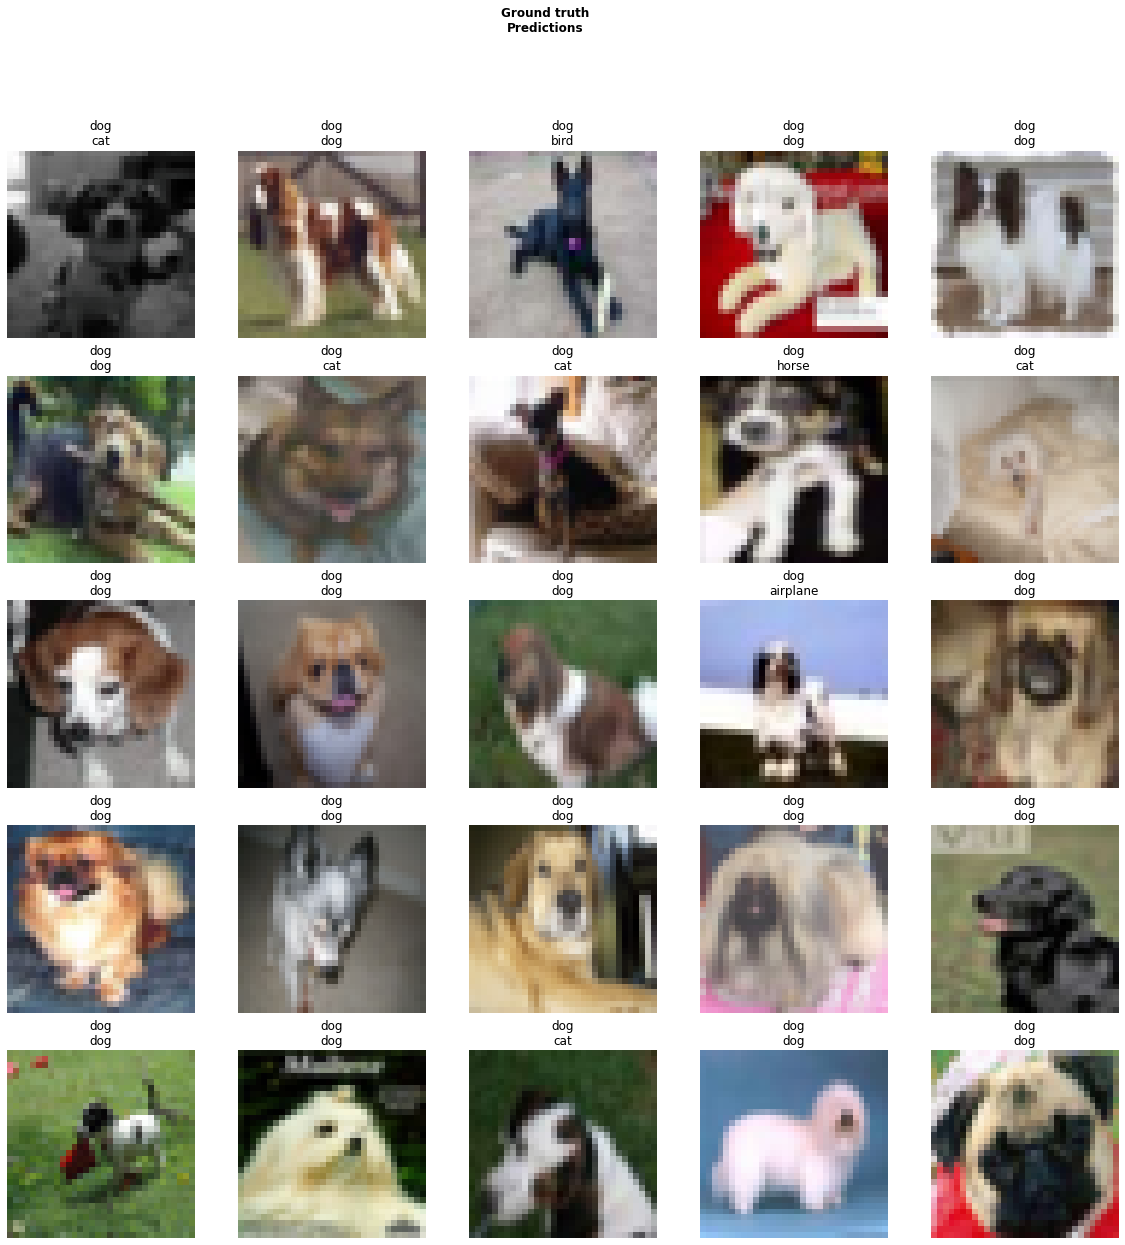

In [50]:
learn.show_results()

### FeatureLoss

In [0]:
class featureloss_mod(nn.Module):
    def __init__(self):
        super(featureloss_mod, self).__init__()

        self.autoencoder = torch.load("featureLoss-Cifar10.pt")
        self.classifier = torch.load("baselineClassification.pt")
        self.mean = torch.tensor(imagenet_stats[0]).cuda()
        self.std = torch.tensor(imagenet_stats[1]).cuda()

    def forward(self, x):
        x = torch.clamp(self.autoencoder(x), min=0, max=1)
        x = (x - self.mean[...,None,None])/self.std[...,None,None]
        x = self.classifier(x)
        return x

In [0]:
featureloss_evaluation = featureloss_mod()
learn = Learner(data, featureloss_evaluation, metrics = [error_rate, accuracy])

In [53]:
learn.validate(learn.data.valid_dl)

[1.3560061, tensor(0.3791), tensor(0.6209)]

### Pretrained

#### With pretrained weights

In [0]:
class pretrained_weights(nn.Module):
    def __init__(self):
        super(pretrained_weights, self).__init__()

        self.autoencoder = torch.load("preTrained-Cifar10.pt")
        self.classifier = torch.load("baselineClassification.pt")
        self.mean = torch.tensor(imagenet_stats[0]).cuda()
        self.std = torch.tensor(imagenet_stats[1]).cuda()

    def forward(self, x):
        x = torch.clamp(self.autoencoder(x), min=0, max=1)
        x = (x - self.mean[...,None,None])/self.std[...,None,None]
        x = self.classifier(x)
        return x

In [0]:
pretrained_weights_eval = pretrained_weights()
learn = Learner(data, pretrained_weights_eval, metrics = [error_rate, accuracy])

In [56]:
learn.validate(learn.data.valid_dl)

[3.9641206, tensor(0.7667), tensor(0.2333)]

#### With weights trained from scratch

In [0]:
class resnet_model(nn.Module):
    def __init__(self):
        super(resnet_model, self).__init__()

        self.autoencoder = torch.load("preTrainednonwWeights-Cifar10.pt")
        self.classifier = torch.load("baselineClassification.pt")
        self.mean = torch.tensor(imagenet_stats[0]).cuda()
        self.std = torch.tensor(imagenet_stats[1]).cuda()

    def forward(self, x):
        x = torch.clamp(self.autoencoder(x), min=0, max=1)
        x = (x - self.mean[...,None,None])/self.std[...,None,None]
        x = self.classifier(x)
        return x

In [0]:
resnet_eval = resnet_model()
learn = Learner(data, resnet_eval, metrics = [error_rate, accuracy])

In [59]:
learn.validate(learn.data.valid_dl)

[4.2761784, tensor(0.7764), tensor(0.2236)]

### Pixel Shuffle

In [0]:
class pixelShuffle_model(nn.Module):
    def __init__(self):
        super(pixelShuffle_model, self).__init__()

        self.autoencoder = torch.load("pixelShuffle-Cifar10.pt")
        self.classifier = torch.load("baselineClassification.pt")
        self.mean = torch.tensor(imagenet_stats[0]).cuda()
        self.std = torch.tensor(imagenet_stats[1]).cuda()

    def forward(self, x):
        x = torch.clamp(self.autoencoder(x), min=0, max=1)
        x = (x - self.mean[...,None,None])/self.std[...,None,None]
        x = self.classifier(x)
        return x

In [0]:
pixelShuffle_eval = pixelShuffle_model()
learn = Learner(data, pixelShuffle_eval, metrics = [error_rate, accuracy])

In [62]:
learn.validate(learn.data.valid_dl)

[2.1444964, tensor(0.5241), tensor(0.4759)]

### Progressive Resizing

In [0]:
class progResize_model(nn.Module):
    def __init__(self):
        super(progResize_model, self).__init__()

        self.autoencoder = torch.load("progResizing-Cifar10.pt")
        self.classifier = torch.load("baselineClassification.pt")
        self.mean = torch.tensor(imagenet_stats[0]).cuda()
        self.std = torch.tensor(imagenet_stats[1]).cuda()

    def forward(self, x):
        x = torch.clamp(self.autoencoder(x), min=0, max=1)
        x = (x - self.mean[...,None,None])/self.std[...,None,None]
        x = self.classifier(x)
        return x

In [0]:
progResize_eval = progResize_model()
learn = Learner(data, progResize_eval, metrics = [error_rate, accuracy])

In [66]:
learn.validate(learn.data.valid_dl)

[2.2437873, tensor(0.5392), tensor(0.4608)]